# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import numpy as np
import speckleret as spr
import speckleret.torch as tspr
import torch
import h5py

from waveoptics.plots.plots import complex_to_hsv


def _keep_keys(dictionary: dict, keys_to_keep: list[str]) -> dict:
    if keys_to_keep is None:
        return dictionary
    else:
        return {key: value for key, value in dictionary.items() if key in keys_to_keep}

def load_h5file(filepath: str, keys: list[str] = None) -> dict:
    with h5py.File(filepath, 'r') as hf:
        loaded_data = {}
        for key in hf.keys():
            loaded_data[key] = np.array(hf[key])
    return _keep_keys(loaded_data, keys)

def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = torch.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

Load the interferometric data

dict_keys(['data'])


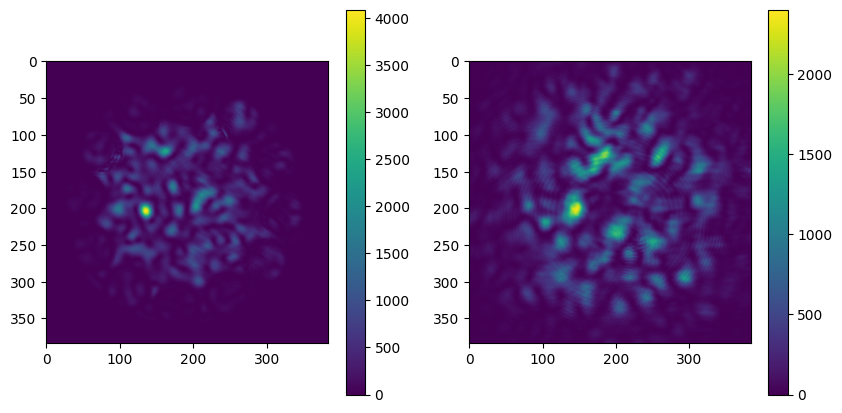

In [3]:
def load_dataset(filepath: str) -> np.ndarray:
    data = load_h5file(filepath)
    print(data.keys())
    NF, FF = data['data'][..., 0], data['data'][..., 1]
    return NF, FF


data_path = r'C:\Users\saucourt\Downloads'
data_file = r'Article_reply_dataset_1000.h5'
NFs, FFs = load_dataset(os.path.join(data_path, data_file))

idx = np.random.randint(0, len(NFs))
NF = NFs[idx, ...]
FF = FFs[idx, ...]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(NF, vmin=0, aspect='equal')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(FF, vmin=0, aspect='equal')
plt.colorbar()

### Data preparation

Select data for phase retrieval

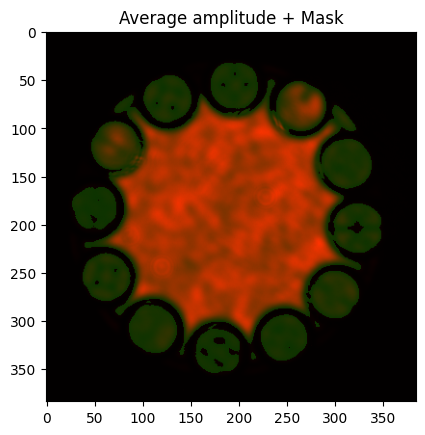

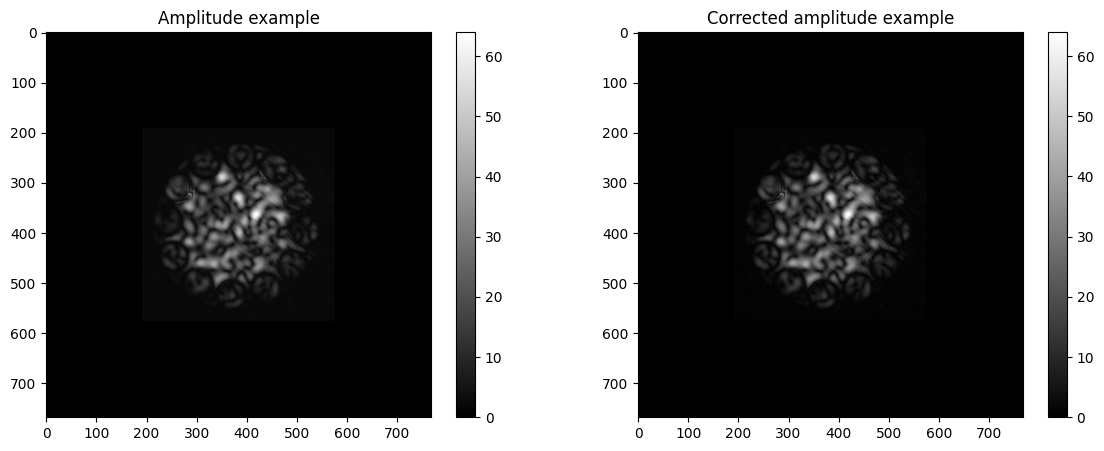

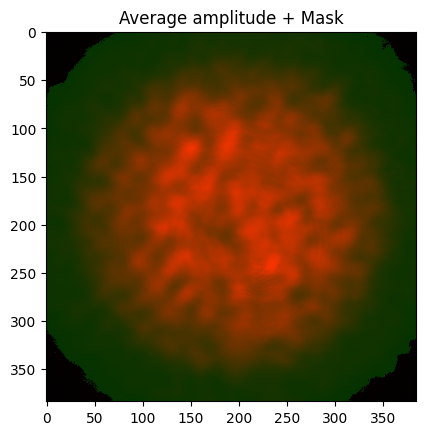

Noise corrections: NF = 4.297433132595486, FF = 0.4670126003689236
Window size: 589


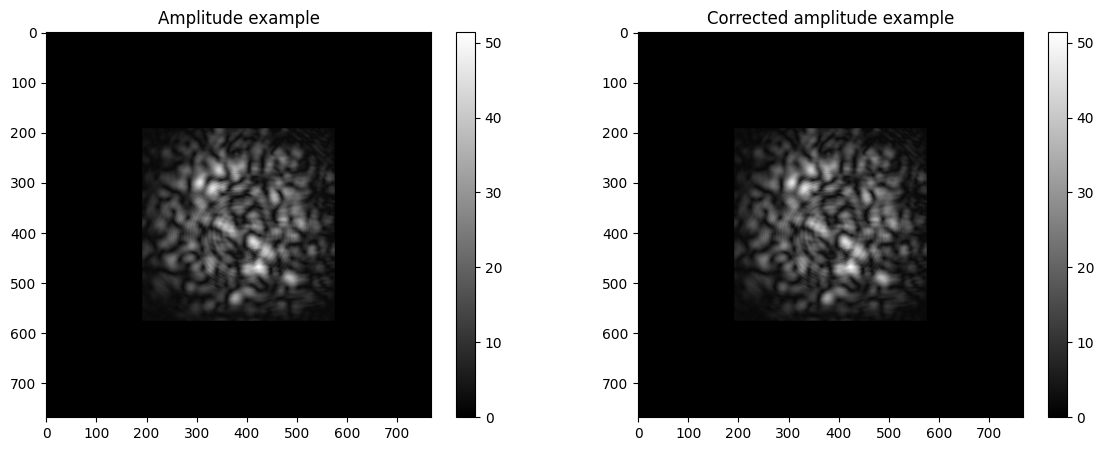

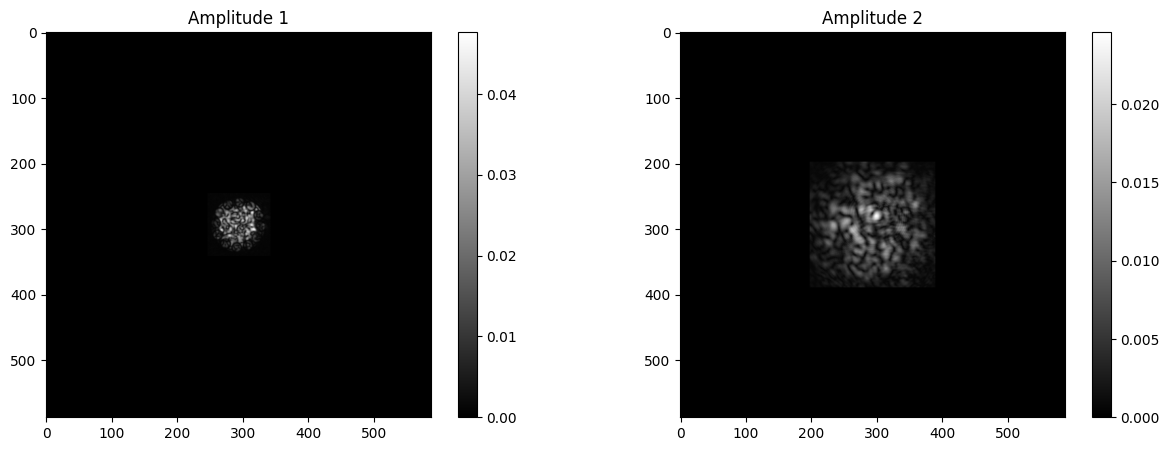

In [7]:
def prepare_all_fields(NFs: np.ndarray, FFs: np.ndarray, bin_nf: int = 4, bin_ff: int = 4) -> tuple[np.ndarray, np.ndarray]:
    noise_NF = spr.utils.extract_noise_correction(NFs[:100, ...], averaging_axis=(0,), mask_trsh=0.05, plot_result=True, plot_mask=True)
    noise_FF = spr.utils.extract_noise_correction(FFs[:100, ...], averaging_axis=(0,), mask_trsh=0.02, plot_result=True, plot_mask=True)
    print(f"Noise corrections: NF = {noise_NF}, FF = {noise_FF}")

    N_window = compute_N_win(561.4e-9, 100e-3, bin_nf * 3.45e-6, bin_ff * 3.45e-6)
    print(f"Window size: {N_window}")

    near_fields, far_fields = [], []
    for idx in range(len(NFs)):
        # Prepare near field
        nf = np.sqrt(np.abs(NFs[idx, ...] - noise_NF))
        nf = spr.utils.bin_image(nf, factor=bin_nf)
        nf_shape = nf.shape
        nf_pad = (N_window - nf_shape[0]) // 2
        nf = np.pad(nf, [nf_pad, nf_pad])
        nf_energy = np.sum(np.square(np.abs(nf)))
        nf = nf / np.sqrt(nf_energy)

        # Prepare far field
        ff = np.sqrt(np.abs(FFs[idx, ...] - noise_FF))
        ff = spr.utils.bin_image(ff, factor=bin_ff)
        ff_shape = ff.shape
        ff_pad = (N_window - ff_shape[0]) // 2
        ff = np.pad(ff, [ff_pad, ff_pad])
        ff = np.flip(ff, axis=0)
        ff_energy = np.sum(np.square(np.abs(ff)))
        ff = ff / np.sqrt(ff_energy)

        if idx == 0:
            _ = spr.plots.compare_arrays(nf, ff, cmap='gray')

        near_fields.append(nf)
        far_fields.append(ff)

    return np.stack(near_fields, axis=0), np.stack(far_fields, axis=0)

near_fields, far_fields = prepare_all_fields(NFs[:500, ...], FFs[:500, ...], bin_nf=4, bin_ff=2)

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

In [4]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = 50

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

NameError: name 'field' is not defined

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

torch.Size([500, 1, 588, 588]) torch.Size([500, 1, 588, 588])


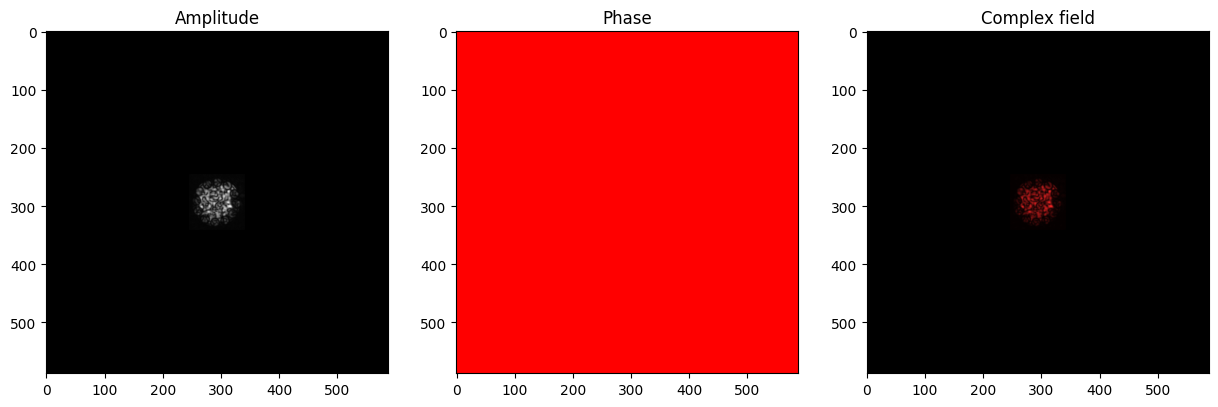

In [8]:
nf_t = torch.from_numpy(near_fields).to(torch.float)
nf_t = nf_t.unsqueeze(1)

ff_t = torch.from_numpy(far_fields).to(torch.float)
ff_t = ff_t.unsqueeze(1)
print(nf_t.shape, ff_t.shape)

support_nf = tspr.supports.threshold_support(nf_t, threshold=0.00)
supported_nf = tspr.transforms.apply_support(nf_t, support_nf)
_ = spr.plots.complex_imshow(supported_nf[0, ...].cpu().detach().numpy().squeeze())

In [9]:
import torch.optim as optim

device = 'cuda'

nf_t = nf_t.to(device)
ff_t = ff_t.to(device)
support_nf = support_nf.to(device)

if device.startswith("cuda"):
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

results = []

x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(nf_t), torch.abs(ff_t)),
        support=support_nf,
        init=tspr.initializers.flat_phases(torch.abs(nf_t)),
        # init=tspr.initializers.random_phases(torch.abs(nf_t)),
        algorithm=tspr.retrieval.RAAR,
        algorithm_kwargs={'beta': 0.90},
        max_iter=200,
)
results.append(result)

x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(nf_t), torch.abs(ff_t)),
        support=support_nf,
        init=x,
        algorithm=tspr.retrieval.ER,
        max_iter=100,
)
results.append(result)

end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)
print(f"Total time: {elapsed_time_ms/1000:.4f} seconds")

x_hat = x
y_hat = tspr.transforms.fourier_transform(x_hat)

Total time: 65.7218 seconds


In [10]:
x.dtype

torch.complex64

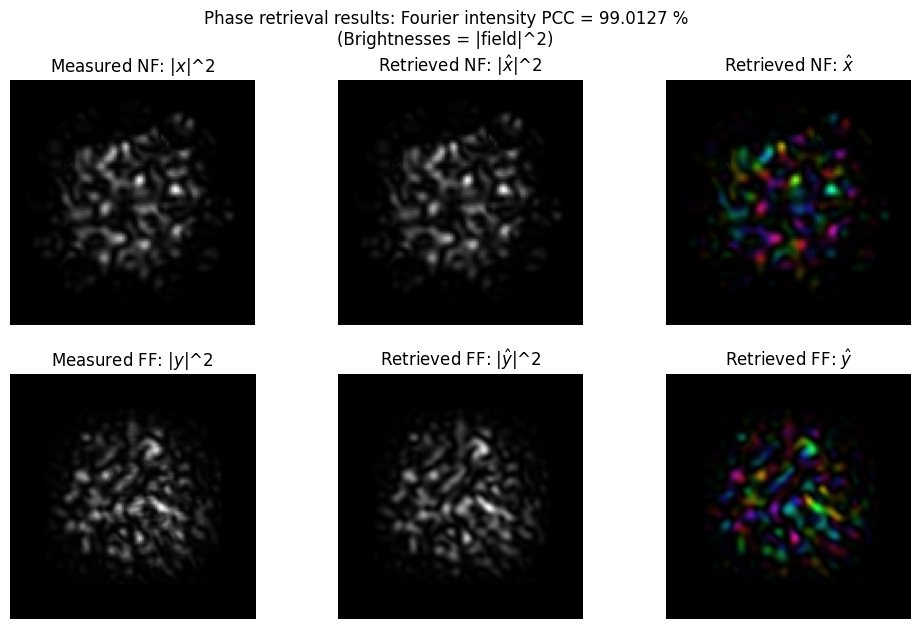

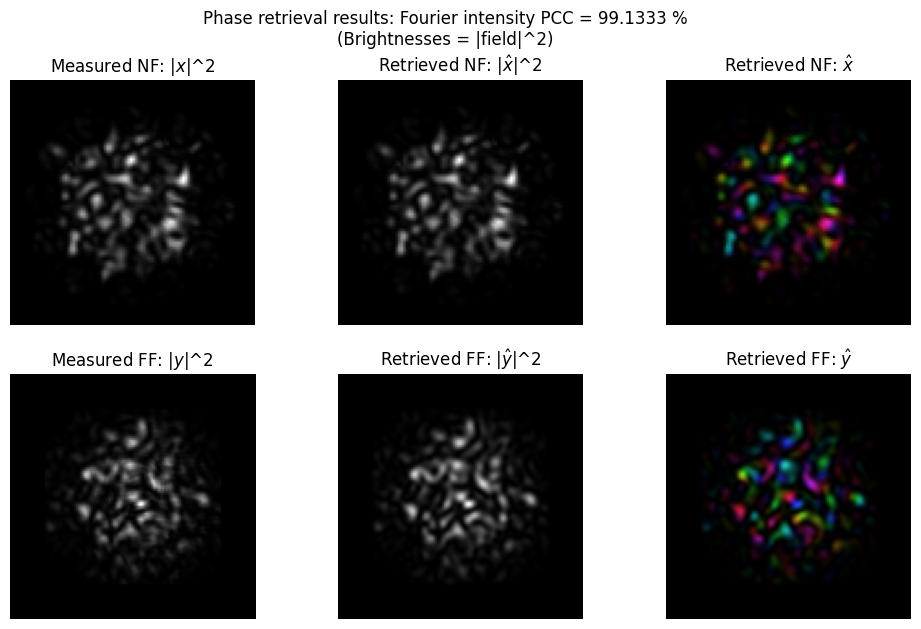

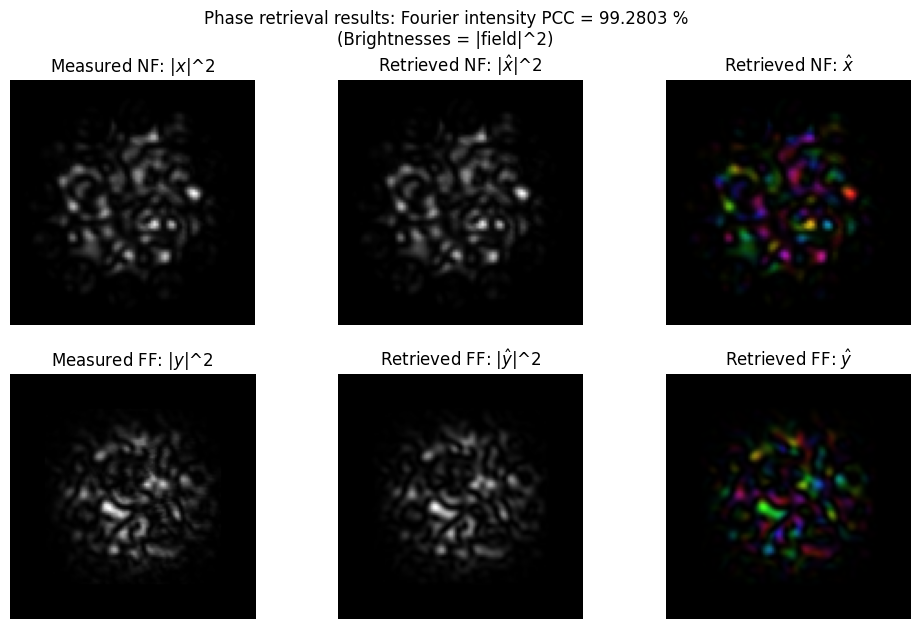

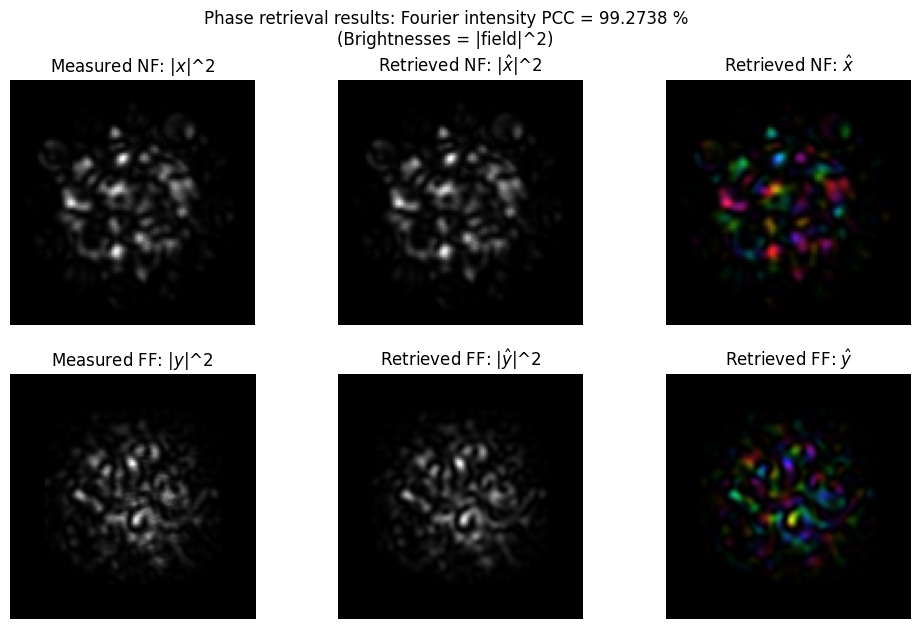

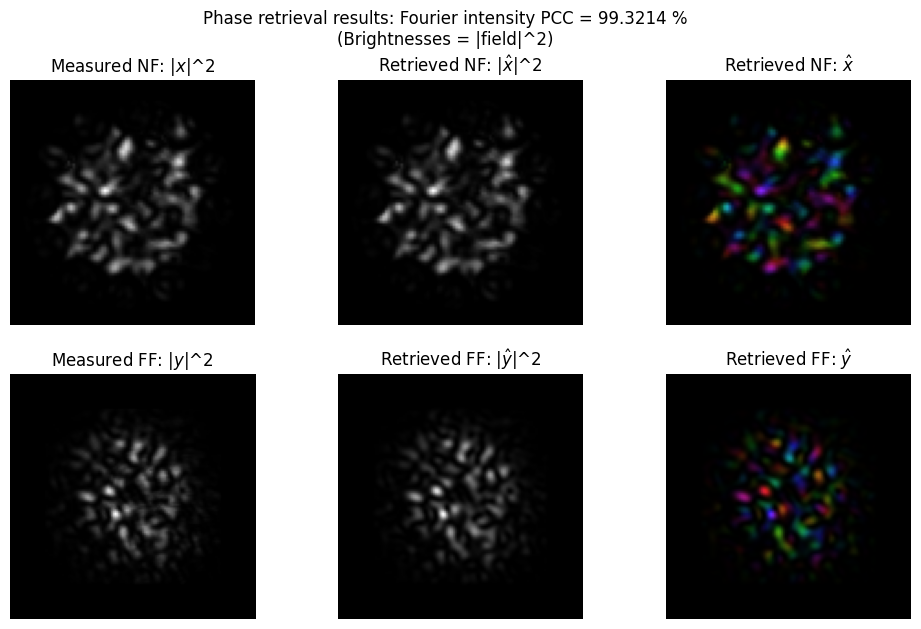

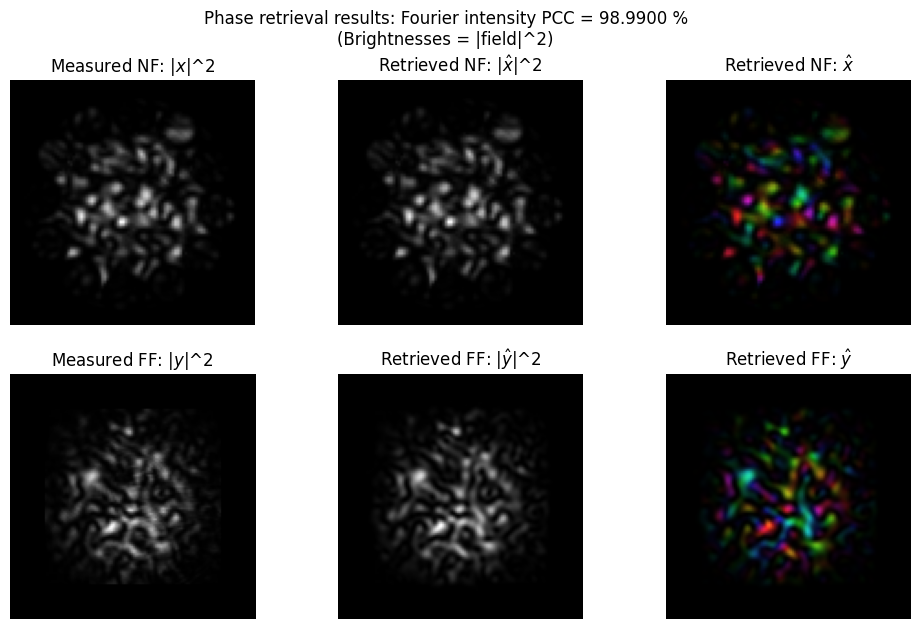

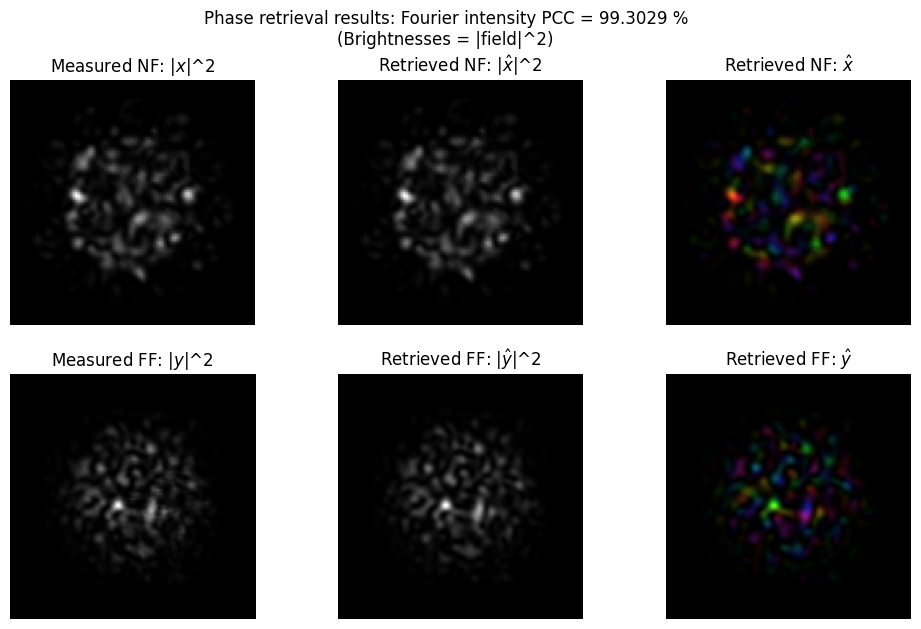

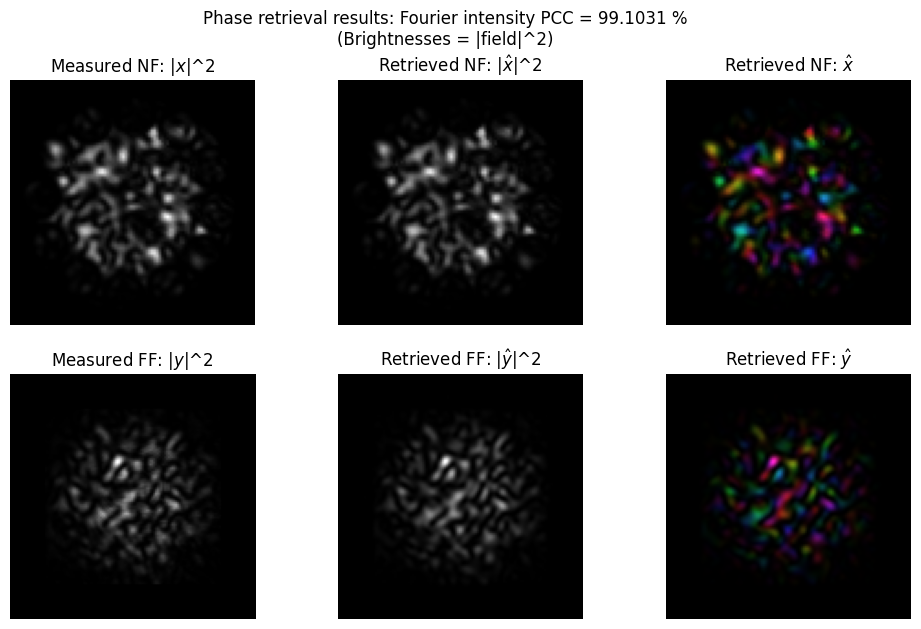

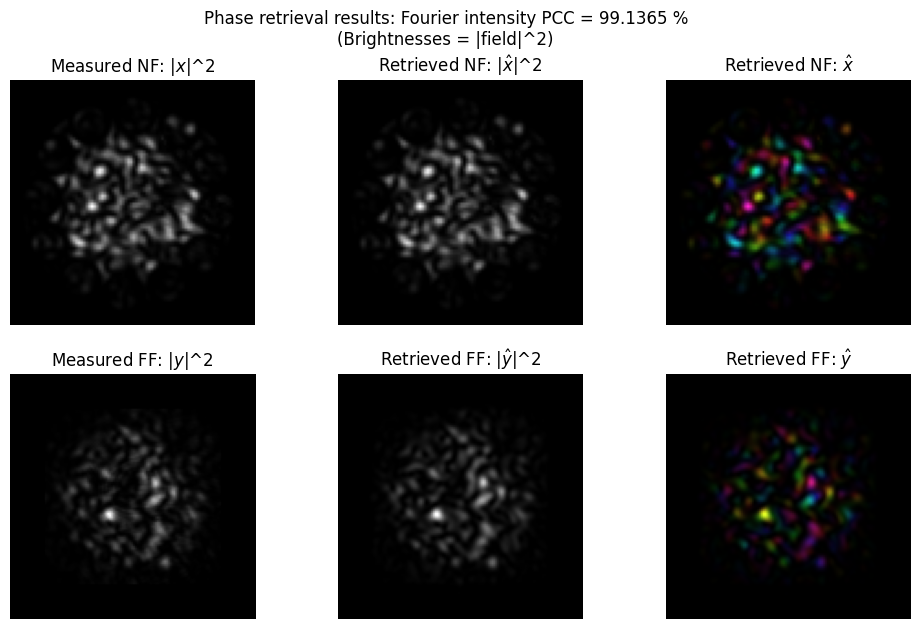

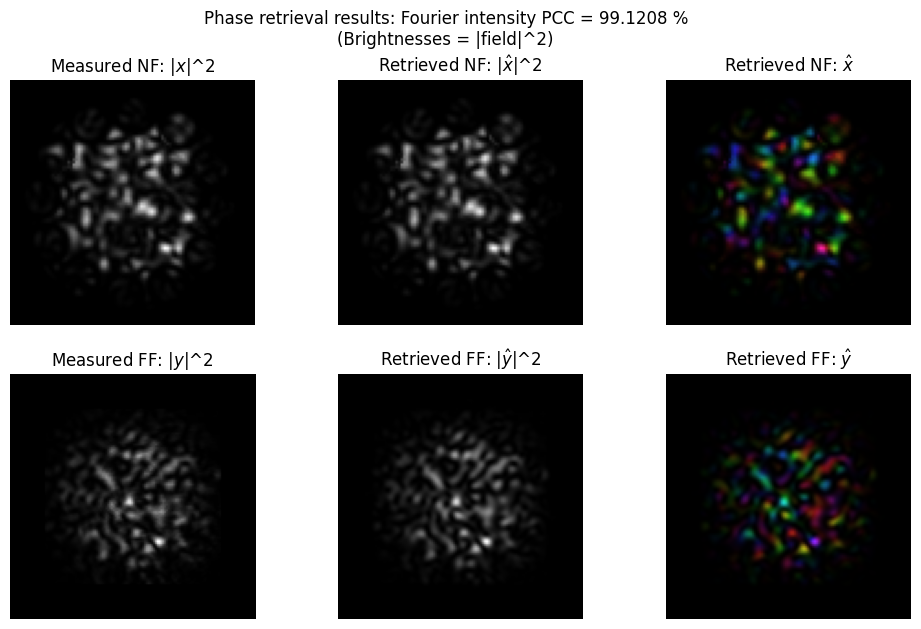

In [33]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'   # <-- keeps fonts as text
mpl.rcParams['text.usetex'] = False

save_path = r'R:\Axe-Photonique\Phocal\Jérémy Saucourt\data_siwar\pr_figures'

for i in range(10):
    idx = np.random.randint(0, len(x_hat))

    hfig = spr.retrievalmath.show_retrieved_fields(
        nf_t[idx, ...].cpu().detach().squeeze().numpy(),
        ff_t[idx, ...].cpu().detach().squeeze().numpy(),
        x_hat[idx, ...].cpu().detach().squeeze().numpy(),
        y_hat[idx, ...].cpu().detach().squeeze().numpy(),
        power=2,
        window_crop=100,
        window_crop_ff=80,
    )

    plt.savefig(os.path.join(save_path, f'example_retrieved_speckle_{i+1}.svg'), format="svg")
    plt.savefig(os.path.join(save_path, f'example_retrieved_speckle_{i+1}.png'))

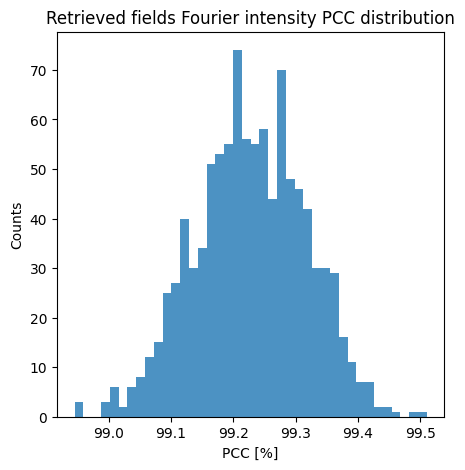

In [34]:
from waveoptics.metrics.numpy import pearson

def compute_ff_pcc_distribution(nf, ff, x_hat, y_hat, power=2,crop_ff: int = 1):
    n_fields = nf.shape[0]
    pearson_nf, pearson_ff = [], []

    cropped_ff = slice(crop_ff, -crop_ff) if crop_ff >= 1 else slice(0, -1)

    for idx in range(n_fields):
        pearson_ff.append(
            pearson(
                x=np.square(np.abs(y_hat[idx, 0, cropped_ff, cropped_ff])),
                y=np.square(np.abs(np.squeeze(ff[idx, 0, cropped_ff, cropped_ff]))),
            )
        )

    return np.array(pearson_ff)

pff = compute_ff_pcc_distribution(
    nf_t.cpu().detach().numpy(),
    ff_t.cpu().detach().numpy(),
    x_hat.cpu().detach().numpy(),
    y_hat.cpu().detach().numpy(),
    crop_ff = 80,
)

plt.figure(figsize=(5, 5))
plt.hist(pff * 100, bins=40, alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('PCC [%]')
plt.title(f'Retrieved fields Fourier intensity PCC distribution')

plt.savefig(os.path.join(save_path, f'distrib_pcc_int_ff_retrieved_speckles.svg'), format="svg")
plt.savefig(os.path.join(save_path, f'distrib_pcc_int_ff_retrieved_speckles.png'))

C:\Users\saucourt\AppData\Local\Temp\ipykernel_20896\2775932910.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t1), max(t1), color='blue', alpha=0.15, edgecolor='none', linewidth=0)
C:\Users\saucourt\AppData\Local\Temp\ipykernel_20896\2775932910.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t2), max(t2), color='purple', alpha=0.15, edgecolor='none', linewidth=0)


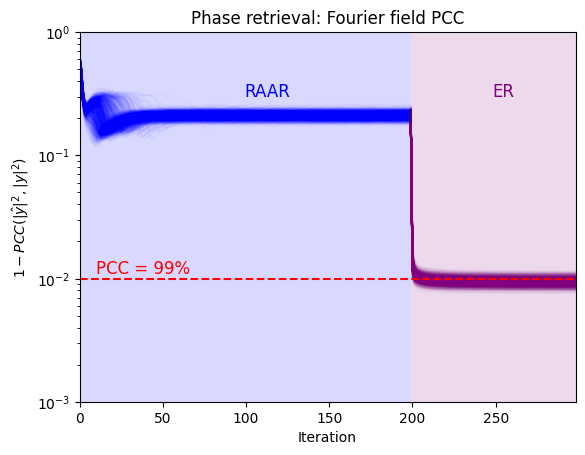

In [35]:
key = 'pearson_fourier'

p1 = results[0][key].cpu()
t1 = torch.arange(0, len(p1))
p2 = results[1][key].cpu()
t2 = torch.arange(len(p1) -1 , len(p1) + len(p2)  -1)

plt.plot(t1, torch.squeeze(p1), label='Algorithm = RAAR', color='blue', alpha=0.02)
plt.plot(t2, torch.squeeze(p2), label='Algorithm = ER', color='purple', alpha=0.02)
plt.axvspan(min(t1), max(t1), color='blue', alpha=0.15, edgecolor='none', linewidth=0)
plt.axvspan(min(t2), max(t2), color='purple', alpha=0.15, edgecolor='none', linewidth=0)
plt.axhline(1e-2, color='r', ls='--')
plt.text(10, 1.1e-2, 'PCC = 99%', fontsize=12, color='red')
plt.text(max(t1) // 2, 3e-1, 'RAAR', fontsize=12, color='blue')
plt.text(max(t1) + (max(t2) - max(t1)) // 2, 3e-1, 'ER', fontsize=12, color='purple')

plt.xlim([0, len(p1) + len(p2)-2])
plt.ylim([1e-3, 1e0])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$1 - PCC(|\hat{y}|^2, |y|^2)$')
# plt.legend()
plt.title('Phase retrieval: Fourier field PCC')


plt.savefig(os.path.join(save_path, f'optim_pr_speckles_dynamics.svg'), format="svg")
plt.savefig(os.path.join(save_path, f'optim_pr_speckles_dynamics.png'))

In [644]:
# np.savez(
#     file=os.path.join(data_path, 'PR_speckles_' + date + f'_idx={idx}' + '.npz'),
#     field=field,
#     fourier=ft,
#     retrieved_field=x_hat.cpu().numpy(),
#     retrieved_fourier=y_hat.cpu().numpy(),
#     pr_results=results,
# )